In [1]:
import sys
sys.path.append('/hpc/projects/group.czii/yue.yu/MyPyLib')

import mrcfile
import napari
import numpy as np
import torch
import torchvision.transforms.functional as TF
import einops
from torch_cubic_spline_grids import CubicBSplineGrid1d, CubicBSplineGrid3d

import matplotlib.pyplot as plt
%matplotlib inline

import py4DSTEM
from libtilt.rotational_averaging import rotational_average_dft_2d
from libtilt.rotational_averaging import rotational_average_dft_2d
from libtilt.grids import patch_grid
from libtilt.filters import bandpass_filter
from libtilt.ctf.ctf_1d import calculate_ctf as calculate_ctf_1d
from libtilt.ctf.ctf_2d import calculate_ctf as calculate_ctf_2d
from libtilt.fft_utils import spatial_frequency_to_fftfreq

In [2]:
# image parameters
IMAGE_DIR = '/hpc/projects/group.czii/yue.yu/ET-user-portal/230808/data_10000'
IMAGE_FILE = IMAGE_DIR + '/TS_030_bin1.mrc'
TILT_FILE = IMAGE_DIR + '/TS_030_bin1.rawtlt'

TILT_AXIS = 84.7 #from .mdoc
PIXEL_SIZE = 3.3702 #.mdoc unit is angstroms, not sure what Alister used
VOLTAGE = 300  # kV
SPHERICAL_ABERRATION = 2.7  # mm # this is not in mdoc 
AMPLITUDE_CONTRAST = 0.10  # fraction
dimention = 3708

# model parameters
GRID_RESOLUTION = (1, 2, 2)  # (t, h, w)

# fitting parameters
N_PATCHES_PER_BATCH = 20
PATCH_SIDELENGTH = 512
DEFOCUS_RANGE = (1, 12)  # microns
FITTING_RANGE = (40, 10)  # angstroms

In [3]:
# model parameters
GRID_RESOLUTION = (1, 2, 2)  # (t, h, w)

In [42]:
image_slice = 30
# read image
image = torch.tensor(mrcfile.read(IMAGE_FILE)[image_slice, :,:]).float()
image = (image - torch.mean(image)) / torch.std(image)
image = einops.repeat(image, 'h w -> 2 h w')  # pretend the target is multi-frame
grid_t, grid_h, grid_w = GRID_RESOLUTION
t, h, w = image.shape
ph, pw = PATCH_SIDELENGTH, PATCH_SIDELENGTH

In [43]:
# extract patches and calculate patch power spectra
patches, patch_centers = patch_grid(
    images=image,
    patch_shape=(1, ph, pw),
    patch_step=(1, ph // 2, pw // 2)
)
patch_ps = torch.abs(torch.fft.rfftn(patches, dim=(-2, -1))) ** 2

# normalise patch centers to [0, 1]
patch_centers = patch_centers / torch.tensor([t - 1, h - 1, w - 1])

In [44]:
# average over dims which are not resolved in desired spatiotemporal grid model
_t = 't' if grid_t > 1 else '1'
_h = 'gh' if grid_h > 1 else '1'
_w = 'gw' if grid_w > 1 else '1'
_reduced_dims = f'{_t} {_h} {_w}'
patch_ps = einops.reduce(
    patch_ps,
    pattern=f't gh gw 1 ph pw -> {_reduced_dims} ph pw',
    reduction='mean',
)

In [45]:
# estimate background in 1D from rotational average of mean power spectrum
mean_power_spectrum = einops.reduce(patch_ps, '... ph pw -> ph pw', reduction='mean')
raps_1d, _ = rotational_average_dft_2d(
    mean_power_spectrum,
    image_shape=(ph, pw),
    rfft=True,
    fftshifted=False,
)
raps_1d = einops.reduce(raps_1d, '... shell -> shell', reduction='mean')

# determine fit range
fftfreq = torch.fft.rfftfreq(PATCH_SIDELENGTH)
lower_limit_fftfreq = spatial_frequency_to_fftfreq(
    1 / FITTING_RANGE[0], spacing=PIXEL_SIZE
)
upper_limit_fftfreq = spatial_frequency_to_fftfreq(
    1 / FITTING_RANGE[1], spacing=PIXEL_SIZE
)
fit_range = torch.logical_and(
    fftfreq > lower_limit_fftfreq, fftfreq < upper_limit_fftfreq
)

# estimate 1D background by fitting a cubic B-spline with 3 control points
background_model = CubicBSplineGrid1d(resolution=3)
background_optimiser = torch.optim.Adam(
    params=background_model.parameters(),
    lr=1
)
raps_1d_in_fit_range = raps_1d[fit_range]
x = torch.linspace(0, 1, steps=len(raps_1d_in_fit_range))
for i in range(200):
    prediction = background_model(x).squeeze()
    loss = torch.mean((torch.log(raps_1d_in_fit_range) - prediction) ** 2)
    loss.backward()
    background_optimiser.step()
    background_optimiser.zero_grad()
    print(loss.item())

# subtract background
background = torch.exp(background_model(x).squeeze())
raps_1d_in_fit_range -= background

155.3701629638672
131.44300842285156
109.57963562011719
89.808349609375
72.14419555664062
56.586448669433594
43.1156120300293
31.690649032592773
22.246017456054688
14.689360618591309
8.899806022644043
4.727606296539307
1.9954684972763062
0.5020310878753662
0.027704421430826187
0.3427635133266449
1.2171802520751953
2.431281089782715
3.786045551300049
5.1118340492248535
6.274576663970947
7.178832054138184
7.76771354675293
8.020028114318848
7.9453125
7.577544689178467
6.968280792236328
6.17983341217041
5.27894926071167
4.331300258636475
3.3969879150390625
2.527099609375
1.7614035606384277
1.1271108388900757
0.6386438012123108
0.2983188033103943
0.0977940782904625
0.020107707008719444
0.04211558774113655
0.137102872133255
0.27735409140586853
0.436484158039093
0.591358482837677
0.7234929800033569
0.8198741674423218
0.8731971383094788
0.881584882736206
0.8478732705116272
0.7785964608192444
0.6827925443649292
0.5707682967185974
0.4529360830783844
0.338815838098526
0.23627029359340668
0.151004

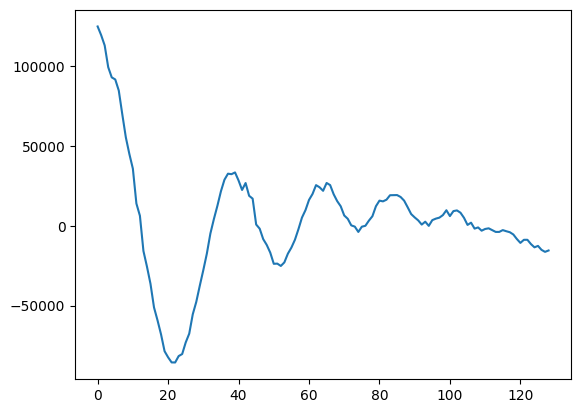

In [46]:
plt.plot(
    raps_1d_in_fit_range.detach().numpy()
)

In [47]:
# simulate a set of 1D ctf^2 at different defoci to find best match
defocus_step = 0.01
test_defoci = torch.arange(
    start=DEFOCUS_RANGE[0],
    end=DEFOCUS_RANGE[1] + defocus_step,
    step=defocus_step,
)
ctf2 = calculate_ctf_1d(
    defocus=test_defoci,
    voltage=VOLTAGE,
    spherical_aberration=SPHERICAL_ABERRATION,
    amplitude_contrast=AMPLITUDE_CONTRAST,
    b_factor=0,
    phase_shift=0,
    pixel_size=PIXEL_SIZE,
    n_samples=PATCH_SIDELENGTH // 2 + 1,
    oversampling_factor=3,
) ** 2

In [48]:
# find best 1D fit by zero normalised cross correlation (ZNCC)
ctf_fit_range = ctf2[:, fit_range]
ctf_fit_range_norm = torch.linalg.norm(ctf_fit_range, dim=-1, keepdim=True)
ctf_fit_range_normed = ctf_fit_range / ctf_fit_range_norm
raps_1d_fit_range_norm = torch.linalg.norm(raps_1d_in_fit_range)
raps_1d_in_fit_range_normed = raps_1d_in_fit_range / raps_1d_fit_range_norm
zncc = einops.einsum(ctf_fit_range_normed, raps_1d_in_fit_range_normed, 'b i, i -> b')

max_correlation_idx = torch.argmax(zncc)
best_defocus = test_defoci[max_correlation_idx]
print(f'best defocus from 1D fit: {best_defocus}')


best defocus from 1D fit: 3.200000047683716


In [49]:
# estimate 2D background and subtract from power spectra
raps_2d, _ = rotational_average_dft_2d(
    dft=mean_power_spectrum,
    image_shape=(ph, pw),
    rfft=True,
    fftshifted=False,
    return_2d_average=True,
)
raps_2d[0, 0] = 0
raps_2d = einops.rearrange(raps_2d, 'h w -> 1 1 h w')
bg_estimate_2d = TF.gaussian_blur(raps_2d, kernel_size=25, sigma=10)
bg_estimate_2d = einops.rearrange(bg_estimate_2d, '1 1 h w -> h w')
patch_ps = patch_ps - bg_estimate_2d

# define spatiotemporal defocus field for 2D+t defocus fitting
defocus_grid_data = torch.ones(size=GRID_RESOLUTION) * best_defocus
defocus_field = CubicBSplineGrid3d.from_grid_data(defocus_grid_data)
defocus_optimiser = torch.optim.Adam(
    params=defocus_field.parameters(),
    lr=0.005,
)

In [50]:
# bandpass filter power spectra to fitting range
filter = bandpass_filter(
    low=lower_limit_fftfreq,
    high=upper_limit_fftfreq,
    falloff=0,
    image_shape=(ph, pw),
    rfft=True,
    fftshift=False,
    device=patch_ps.device
)
patch_ps *= filter

In [51]:
# optimise 2d+t defocus model at grid points
for i in range(200):
    _, ph, pw = patch_centers.shape[:3]
    patch_idx = np.random.randint(
        low=(0, 0), high=(ph, pw), size=(N_PATCHES_PER_BATCH, 2)
    )
    patch_idx_h, patch_idx_w = einops.rearrange(patch_idx, 'b idx -> idx b')
    subset_patch_ps = patch_ps[:, patch_idx_h, patch_idx_w]
    subset_patch_centers = patch_centers[:, patch_idx_h, patch_idx_w]

    predicted_patch_defoci = defocus_field(subset_patch_centers)
    predicted_patch_defoci = einops.rearrange(predicted_patch_defoci, '... 1 -> ...')
    simulated_ctfs = calculate_ctf_2d(
        defocus=predicted_patch_defoci,
        voltage=300,
        spherical_aberration=2.7,
        amplitude_contrast=0.10,
        b_factor=0,
        phase_shift=0,
        pixel_size=PIXEL_SIZE,
        image_shape=(PATCH_SIDELENGTH, PATCH_SIDELENGTH),
        astigmatism=0,
        astigmatism_angle=0,
        rfft=True,
        fftshift=False,
    ) ** 2  # (t ph pw h w)
    simulated_ctfs *= filter

    # zero gradients, calculate loss and backpropagate
    defocus_optimiser.zero_grad()
    loss = torch.mean((subset_patch_ps - simulated_ctfs) ** 2).sqrt()
    loss.backward()
    defocus_optimiser.step()

    if i % 5 == 0:
        print(loss.item())
        print(defocus_field.data)

149227.890625
tensor([[[[3.1950, 3.1950],
          [3.2050, 3.2050]]]])
152600.453125
tensor([[[[3.1706, 3.1740],
          [3.2278, 3.2281]]]])
146940.359375
tensor([[[[3.1523, 3.1660],
          [3.2502, 3.2520]]]])
150539.875
tensor([[[[3.1332, 3.1580],
          [3.2728, 3.2765]]]])
147641.421875
tensor([[[[3.1129, 3.1450],
          [3.2948, 3.3001]]]])
146445.046875
tensor([[[[3.0917, 3.1319],
          [3.3142, 3.3225]]]])
148737.921875
tensor([[[[3.0704, 3.1182],
          [3.3299, 3.3436]]]])
147553.703125
tensor([[[[3.0486, 3.1041],
          [3.3434, 3.3642]]]])
148913.609375
tensor([[[[3.0257, 3.0880],
          [3.3530, 3.3816]]]])
146114.484375
tensor([[[[3.0041, 3.0713],
          [3.3599, 3.3980]]]])
146807.328125
tensor([[[[2.9862, 3.0632],
          [3.3667, 3.4143]]]])
150237.3125
tensor([[[[2.9716, 3.0610],
          [3.3746, 3.4314]]]])
146472.59375
tensor([[[[2.9592, 3.0614],
          [3.3824, 3.4468]]]])
148124.828125
tensor([[[[2.9490, 3.0658],
          [3.39

In [52]:
# evaluate defocus over grid
_t, _y, _x = (
    torch.linspace(0, 1, steps=1),
    torch.linspace(0, 1, steps=h // 10),
    torch.linspace(0, 1, steps=w // 10),
)
tt, yy, xx = torch.meshgrid(_t, _y, _x, indexing='ij')
tyx = einops.rearrange([tt, yy, xx], 'tyx t h w -> t h w tyx')
defocus = defocus_field(tyx)

(-1.8931279, 2.2056475)

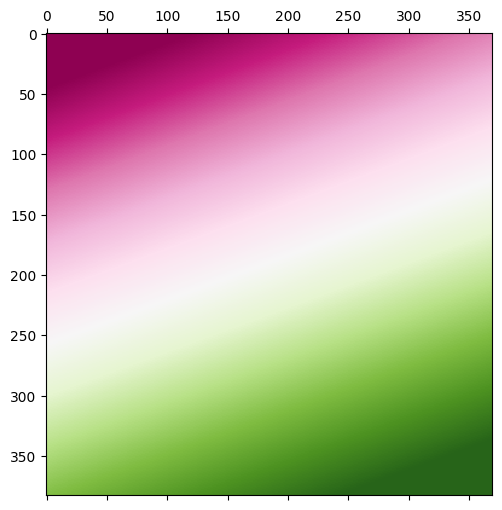

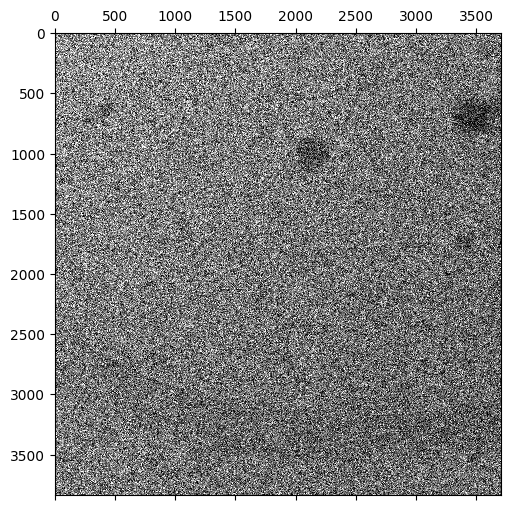

In [53]:
figsize=((6,6))

py4DSTEM.visualize.show(
    defocus.detach().numpy()[0,:,:,0],
    return_intensity_range=True,
    cmap='PiYG',
    figsize=figsize,
)
py4DSTEM.visualize.show(
    image.detach().numpy()[0,:,:],
    return_intensity_range=True,
    figsize=figsize
)